- [Очистка данных](#Очистка-данных)
- [Визуальный анализ](#Визуальный-анализ)

In [1]:
import numpy as np
import pandas as pd

from utils import definitions as defs
from utils import visualization as viz

In [2]:
df = pd.read_excel(defs.ETLED_DATA_PATH_step_1)

In [3]:
# для визуализации распределения по классами
norm_old = (df[defs.LABEL] == defs.LABELS[0]).sum()
benign_tumor_old = (df[defs.LABEL] == defs.LABELS[1]).sum()
malignant_tumor_old = (df[defs.LABEL] == defs.LABELS[2]).sum()

# Очистка данных

## 2. Возраст

На прошлом шаге ETL выбросы возраста были заменены на NaN. Для данного признака значение NaN недопустимо, поэтому удаляем эти точки.

In [4]:
df = df[df[defs.QUESTION_2].notnull()]  # 595 - 2 = 593

## 4. Если имеете супруга или партнёра, как долго вы живёте вместе? (в годах)

По идее, для данного признака недопустимо иметь значения NaN в тех точках, которые в Признаке 3 (Семейное положение) имели значения 'замужем', 'имею гражданского супруга'. А те точки данных, что в Признаке 3 имеют значения 'одинока', 'разведена', 'вдова' в этом признаке должны иметь значения NaN.  

Возможно это связано с тем, что Признак 3 некорректно составлен. На него нужно дать один ответ, хотя верными могут быть несколько. Например, женщина может быть вдовой и при этом иметь гражданского супруга, и т.п.

In [5]:
num = df.loc[(df[defs.QUESTION_3].isin([defs.ANSWER_3_1, defs.ANSWER_3_2])), defs.QUESTION_4].isnull().sum()
print(f'Имеют в Признаке 3 "замужем"/"имею гражданского супруга", но НЕ ИМЕЮТ значения в Признаке 4 - {num} шт.')
num = df.loc[(df[defs.QUESTION_3].isin([defs.ANSWER_3_3, defs.ANSWER_3_4, defs.ANSWER_3_5])), defs.QUESTION_4].notnull().sum()
print(f'Имеют в Признаке 3 "одинока"/"разведена"/"вдова", но ИМЕЮТ значения в Признаке 4 - {num} шт.')

Имеют в Признаке 3 "замужем"/"имею гражданского супруга", но НЕ ИМЕЮТ значения в Признаке 4 - 37 шт.
Имеют в Признаке 3 "одинока"/"разведена"/"вдова", но ИМЕЮТ значения в Признаке 4 - 11 шт.


Моя реализация дерева решений не может разделять множество точек даных по признаку с пустыми значениями. Поэтому я ввожу вспомогательный Признак 'pre4. Есть ответ на вопрос 4?', чтобы сначала разделить множество по нему, а далее работать с Признаком 4.

In [6]:
df.loc[df[defs.QUESTION_4].isnull(),'pre4. Есть ответ на вопрос 4?'] = defs.NO
df.loc[df[defs.QUESTION_4].notnull(), 'pre4. Есть ответ на вопрос 4?'] = defs.YES

## 5. В какой семье Вы выросли?

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [7]:
df = df[df[defs.QUESTION_5].isin(defs.ANSWERS_5)]  # 593 - 1 = 592

## 7. Если да, как часто вы общаетесь?

По идее для точек, которые в Признаке 6 (Жив ли хотя бы один из Ваших родителей?) имели значение 'да', должно быть значение в данном Признаке. С этим всё в порядке. И наоборот для точек, которые в Признаке 6 имели значение 'нет', не должно быть значения. Такая точка есть. Её удаляю.

In [8]:
num = df.loc[df[defs.QUESTION_6] == defs.YES, defs.QUESTION_7].isnull().sum()
print(f'Имеют в Признаке 6 "да", но НЕ ИМЕЮТ значения в Признаке 7 - {num} шт.')
num = df.loc[df[defs.QUESTION_6] == defs.NO, defs.QUESTION_7].notnull().sum()
print(f'Имеют в Признаке 6 "нет", но ИМЕЮТ значения в Признаке 7 - {num} шт.')

Имеют в Признаке 6 "да", но НЕ ИМЕЮТ значения в Признаке 7 - 0 шт.
Имеют в Признаке 6 "нет", но ИМЕЮТ значения в Признаке 7 - 1 шт.


In [9]:
tmp = df[df[defs.QUESTION_6] == defs.NO]
index = tmp[tmp[defs.QUESTION_7].notnull()].index
df = df.drop(index=index)  # 592 - 1 = 591

## 9. Если да, сколько?

По идее для точек, которые в Признаке 8 (8. Есть ли у Вас дети?) имели значение 'да', должно быть значение в данном Признаке. С этим всё в порядке. И наоборот для точек, которые в Признаке 8 имели значение 'нет', не должно быть значения. Такая точка есть. Её удаляю.

In [10]:
tmp = df[df[defs.QUESTION_8] == defs.NO]
index = tmp[tmp[defs.QUESTION_9].notnull()].index
df = df.drop(index=index)  # 591 - 1 = 590

## 10. Есть ли у Вас совершеннолетние дети? (да/нет)

С этим Признаком совсем всё плохо: стоит только взглянуть на распределение ответов. Однозначно дропаю его.

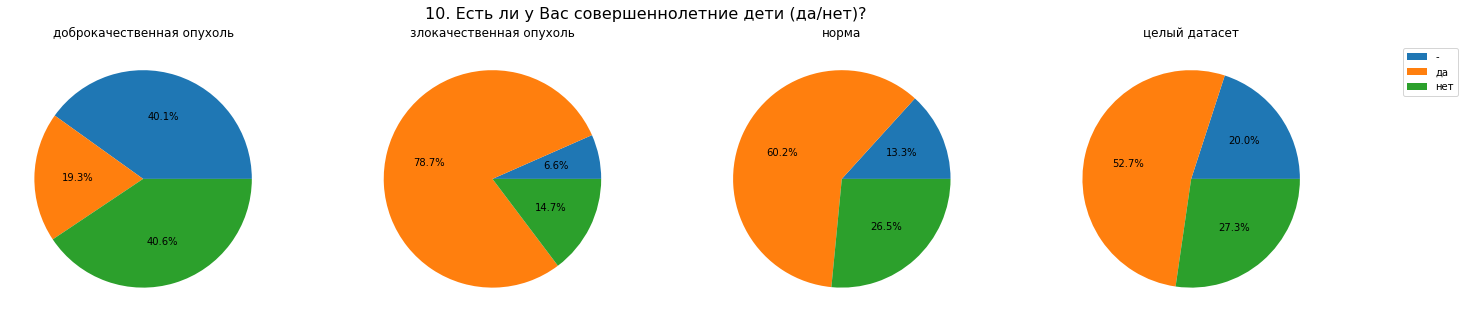

In [11]:
viz.plot_pies(df, defs.QUESTION_10, defs.LABEL)

In [12]:
df = df.drop([defs.QUESTION_10], axis=1)

## 11. Если да, как часто вы общаетесь?

По аналогии с Признаком 4 ввожу вспомогательный Признак 'pre11. Есть ответ на вопрос 11?'.

In [13]:
df.loc[df[defs.QUESTION_11].isnull(), 'pre11. Есть ответ на вопрос 11?'] = defs.NO
df.loc[df[defs.QUESTION_11].notnull(), 'pre11. Есть ответ на вопрос 11?'] = defs.YES

## 12. Сколько человек живут вместе с Вами?

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [14]:
df = df[df[defs.QUESTION_12].isin(defs.ANSWERS_12)]  # 590 - 2 = 588

## 15. Есть ли у Вас домашние питомцы? (да/нет)

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [15]:
df = df[df[defs.QUESTION_15].isin([defs.YES, defs.NO])]  # 588 - 1 = 587

## 16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [16]:
df = df[df[defs.QUESTION_16].isin(defs.ANSWERS_16_17_18)]  # 587 - 2 = 585

## 17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [17]:
df = df[df[defs.QUESTION_17].isin(defs.ANSWERS_16_17_18)]  # 585 - 1 = 584

## 20. Каков уровень образования Вашего партнёра? (если применимо)

По аналогии с Признаком 20 ввожу вспомогательный Признак 'pre20. Есть ответ на вопрос 20?'.

In [18]:
num = df.loc[df[defs.QUESTION_3].isin([defs.ANSWER_3_1, defs.ANSWER_3_2]), defs.QUESTION_20].isnull().sum()
print(f'Имеют в Признаке 3 "замужем"/"имею гражданского супруга", но НЕ ИМЕЮТ значения в Признаке 20 - {num} шт.')
num = df.loc[df[defs.QUESTION_3].isin([defs.ANSWER_3_3, defs.ANSWER_3_4, defs.ANSWER_3_5]), defs.QUESTION_20].isnull().sum()
print(f'Имеют в Признаке 3 "одинока"/"разведена"/"вдова", но ИМЕЮТ значения в Признаке 20 - {num} шт.')

Имеют в Признаке 3 "замужем"/"имею гражданского супруга", но НЕ ИМЕЮТ значения в Признаке 20 - 12 шт.
Имеют в Признаке 3 "одинока"/"разведена"/"вдова", но ИМЕЮТ значения в Признаке 20 - 178 шт.


In [19]:
df.loc[df[defs.QUESTION_20].isnull(), 'pre20. Есть ответ на вопрос 20?'] = defs.NO
df.loc[df[defs.QUESTION_20].notnull(), 'pre20. Есть ответ на вопрос 20?'] = defs.YES

## 22. Как долго Вы проживаете в этом месте? (в годах)

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [20]:
df = df[df[defs.QUESTION_22].notnull()]  # 584 - 5 = 579

## 24. Если Вы живёте в многоквартирном доме, то на каком этаже?

In [21]:
num = df.loc[df[defs.QUESTION_23] == defs.ANSWER_23_1, defs.QUESTION_24].isnull().sum()
print(f'Имеют в Признаке 23 "многоквартирный дом", но НЕ ИМЕЮТ значения в Признаке 24 - {num} шт.')
num = df.loc[(df[defs.QUESTION_23].isin([defs.ANSWER_23_2, defs.ANSWER_23_3])), defs.QUESTION_24].notnull().sum()
print(f'Имеют в Признаке 23 "таунхаус"/"собственный дом", но ИМЕЮТ значения в Признаке 24 - {num} шт.')

Имеют в Признаке 23 "многоквартирный дом", но НЕ ИМЕЮТ значения в Признаке 24 - 1 шт.
Имеют в Признаке 23 "таунхаус"/"собственный дом", но ИМЕЮТ значения в Признаке 24 - 9 шт.


In [22]:
index = df.loc[(df[defs.QUESTION_23] == defs.ANSWER_23_1) & df[defs.QUESTION_24].isnull()].index
df = df.drop(index=index)  # 579 - 1 = 578

In [23]:
index = df.loc[df[defs.QUESTION_23].isin([defs.ANSWER_23_2, defs.ANSWER_23_3]) & df[defs.QUESTION_24].notnull()].index
df = df.drop(index=index)  # 578 - 9 = 569

## 25. Каким транспортом Вы обычно пользуетесь?

Для данного признака значение NaN недопустимо, поэтому удаляем точки c ними.

In [24]:
df = df[df[defs.QUESTION_25].isin(defs.ANSWERS_25)]  # 569 - 1 = 568

## 26. Сколько времени занимает Ваш путь до работы в одну сторону?

In [25]:
num = df.loc[df[defs.QUESTION_27].isin([defs.ANSWER_27_1, defs.ANSWER_27_2]), defs.QUESTION_26].isnull().sum()
print(f'Имеют в Признаке 27 "полный рабочий день"/"частичная занятость", но НЕ ИМЕЮТ значения в Признаке 26 - {num} шт.')
num = df.loc[df[defs.QUESTION_27].isin([defs.ANSWER_27_3, defs.ANSWER_27_4]), defs.QUESTION_26].notnull().sum()
print(f'Имеют в Признаке 27 "я работаю из дома"/"я не работаю", но ИМЕЮТ значения в Признаке 26 - {num} шт.')

Имеют в Признаке 27 "полный рабочий день"/"частичная занятость", но НЕ ИМЕЮТ значения в Признаке 26 - 0 шт.
Имеют в Признаке 27 "я работаю из дома"/"я не работаю", но ИМЕЮТ значения в Признаке 26 - 13 шт.


In [26]:
index = df.loc[df[defs.QUESTION_27].isin([defs.ANSWER_27_3, defs.ANSWER_27_4]) & df[defs.QUESTION_26].notnull()].notnull().index
df = df.drop(index=index)  # 568 - 13 = 555

In [27]:
df[defs.QUESTION_16] = df[defs.QUESTION_16].astype('int64')
df[defs.QUESTION_17] = df[defs.QUESTION_17].astype('int64')
df[defs.QUESTION_18] = df[defs.QUESTION_18].astype('int64')

In [28]:
# для визуализации распределения по классами
norm_new = (df[defs.LABEL] == defs.LABELS[0]).sum()
benign_tumor_new = (df[defs.LABEL] == defs.LABELS[1]).sum()
malignant_tumor_new = (df[defs.LABEL] == defs.LABELS[2]).sum()

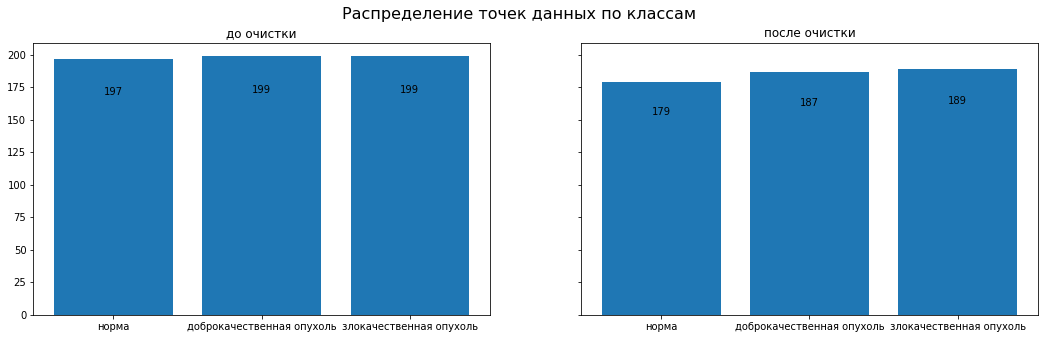

In [29]:
viz.plot_distribution(norm_old, benign_tumor_old, malignant_tumor_old, norm_new, benign_tumor_new, malignant_tumor_new)

In [30]:
df.to_excel(excel_writer=defs.ETLED_DATA_PATH_step_2, index=False)

## Визуальный анализ

### 2. Возраст

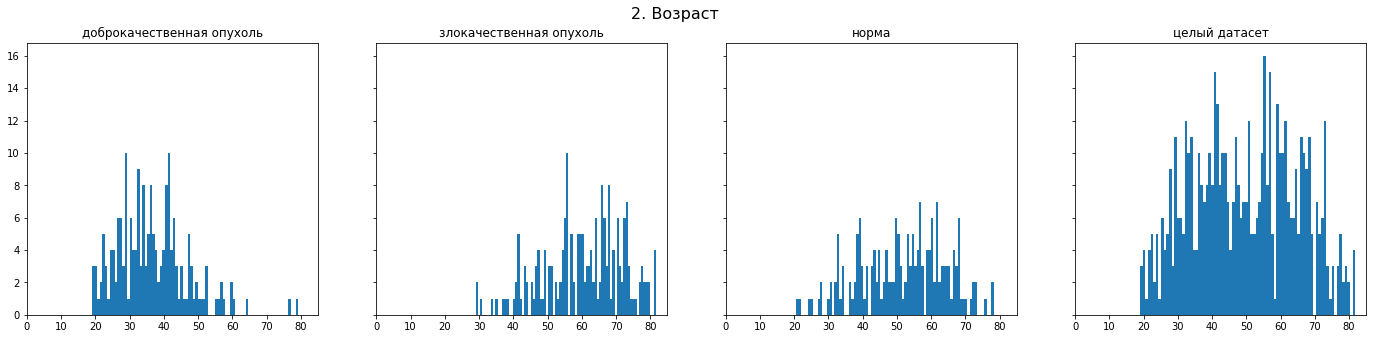

In [31]:
viz.plot_hists(df, defs.QUESTION_2, defs.LABEL, bins=82, xlim=(0, 85))

### 3. Семейное положение

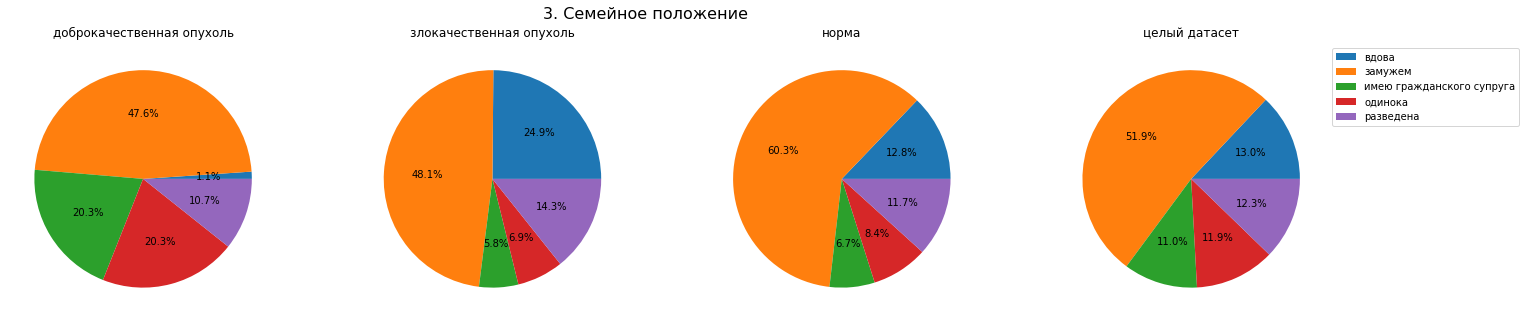

In [32]:
viz.plot_pies(df, defs.QUESTION_3, defs.LABEL)

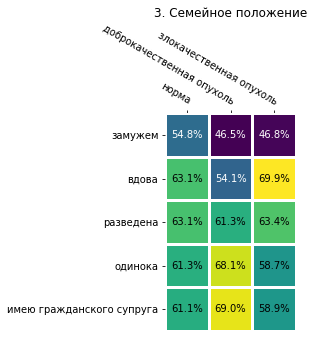

In [33]:
viz.plot_accuracy_matrix(df, defs.QUESTION_3)

### pre4. Есть ответ на 4 вопрос?

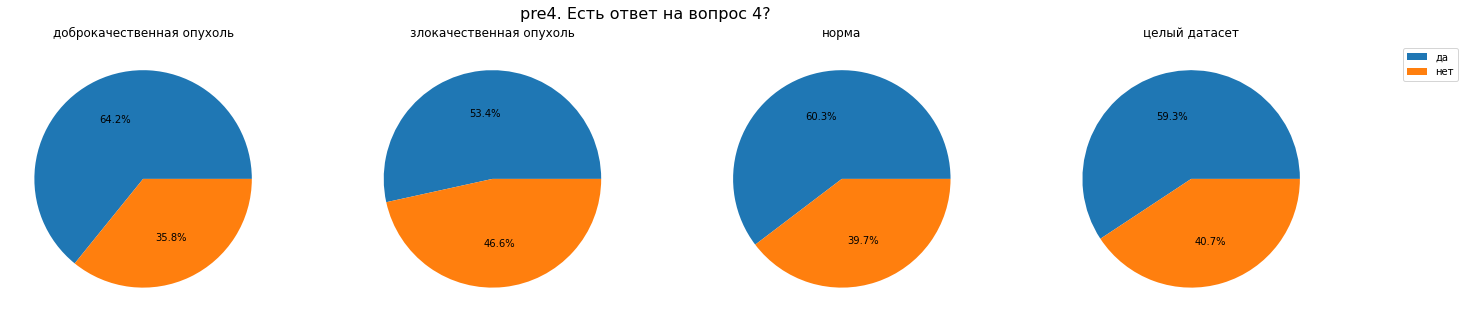

In [34]:
viz.plot_pies(df, 'pre4. Есть ответ на вопрос 4?', defs.LABEL)

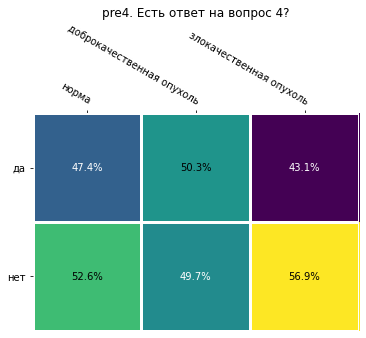

In [35]:
viz.plot_accuracy_matrix(df, 'pre4. Есть ответ на вопрос 4?')

### 4. Если имеете супруга или партнёра, как долго вы живёте вместе (в годах)?

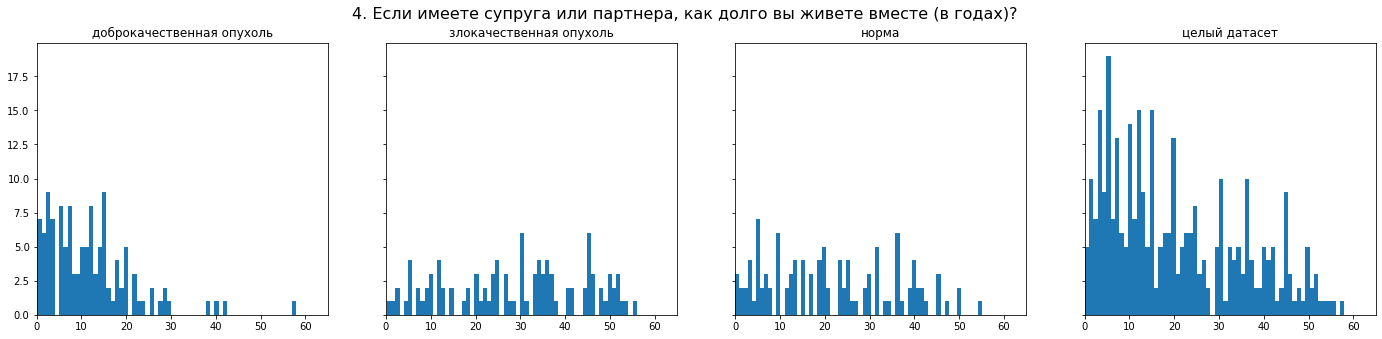

In [36]:
viz.plot_hists(df, defs.QUESTION_4, defs.LABEL, bins=60, xlim=(0, 65))

### 5. В какой семье Вы выросли?

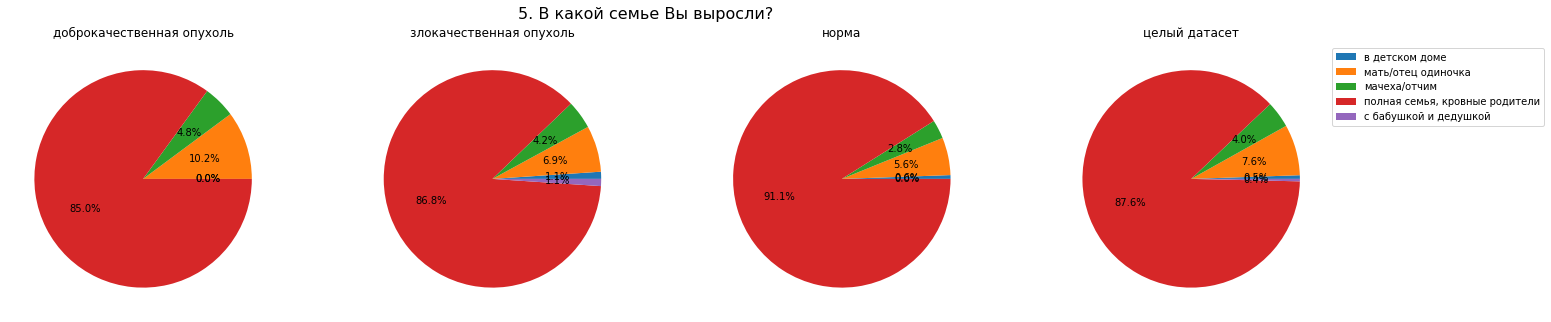

In [37]:
viz.plot_pies(df, defs.QUESTION_5, defs.LABEL)

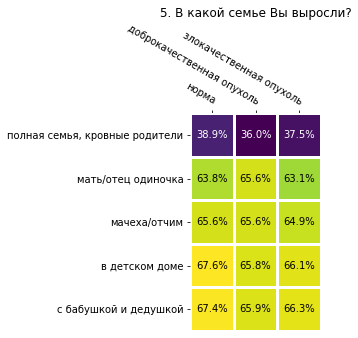

In [38]:
viz.plot_accuracy_matrix(df, defs.QUESTION_5)

### 6. Жив ли хотя бы один из Ваших родителей? (да/нет)

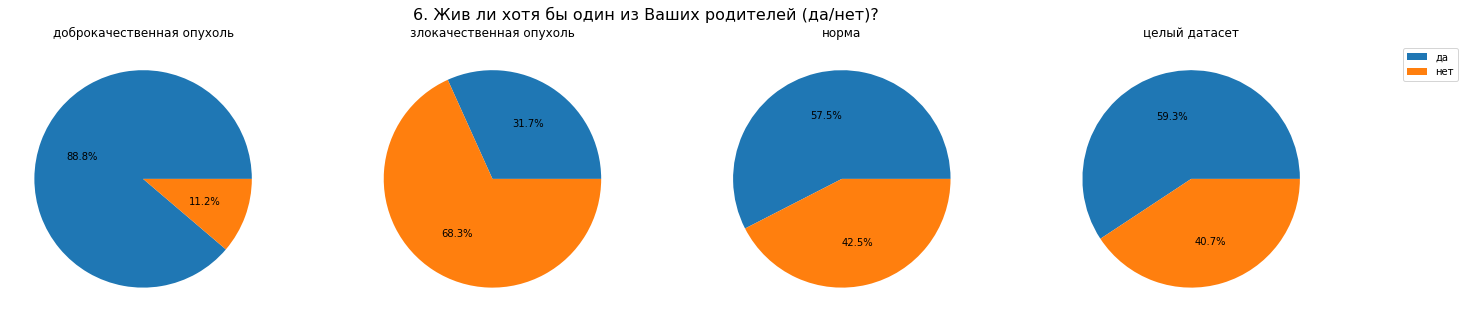

In [39]:
viz.plot_pies(df, defs.QUESTION_6, defs.LABEL)

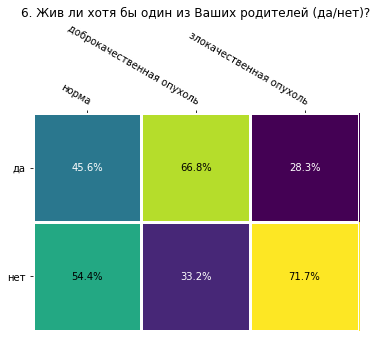

In [40]:
viz.plot_accuracy_matrix(df, defs.QUESTION_6)

### 7. Если да, как часто вы общаетесь?

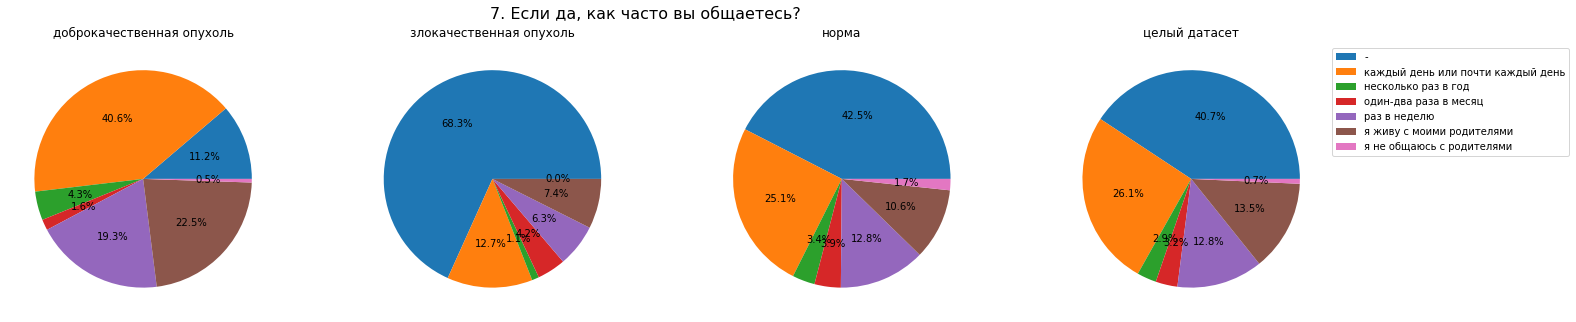

In [41]:
viz.plot_pies(df, defs.QUESTION_7, defs.LABEL)

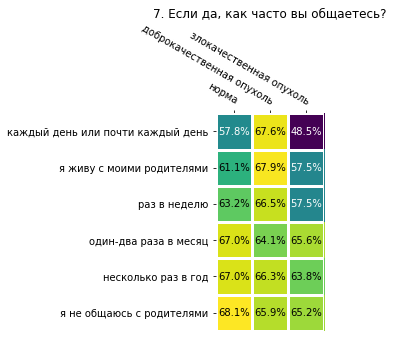

In [42]:
viz.plot_accuracy_matrix(df, defs.QUESTION_7)

### 8. Есть ли у Вас дети? (да/нет)

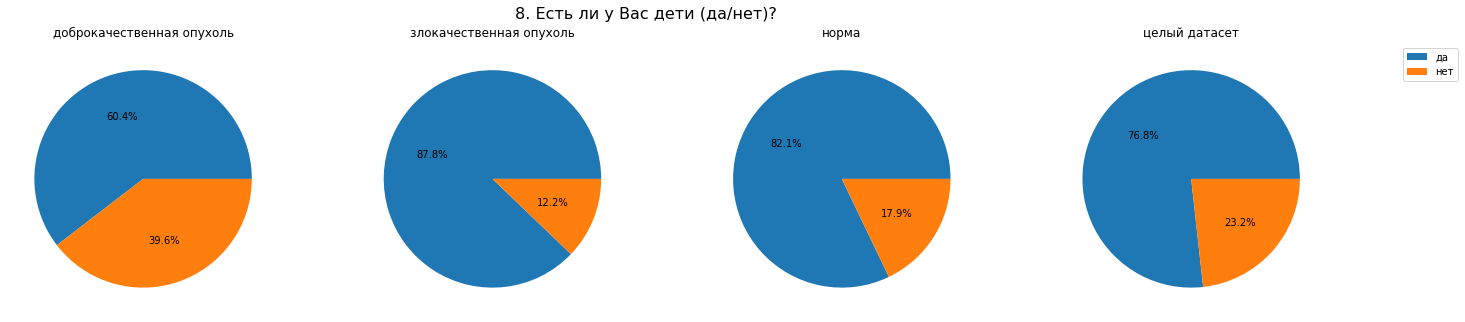

In [43]:
viz.plot_pies(df, defs.QUESTION_8, defs.LABEL)

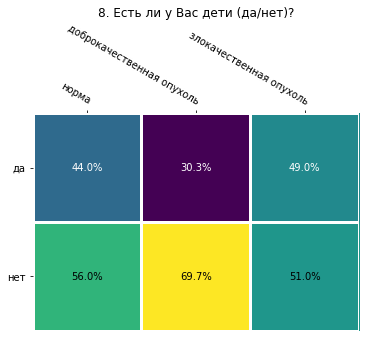

In [44]:
viz.plot_accuracy_matrix(df, defs.QUESTION_8)

### 9. Сколько у Вас детей?

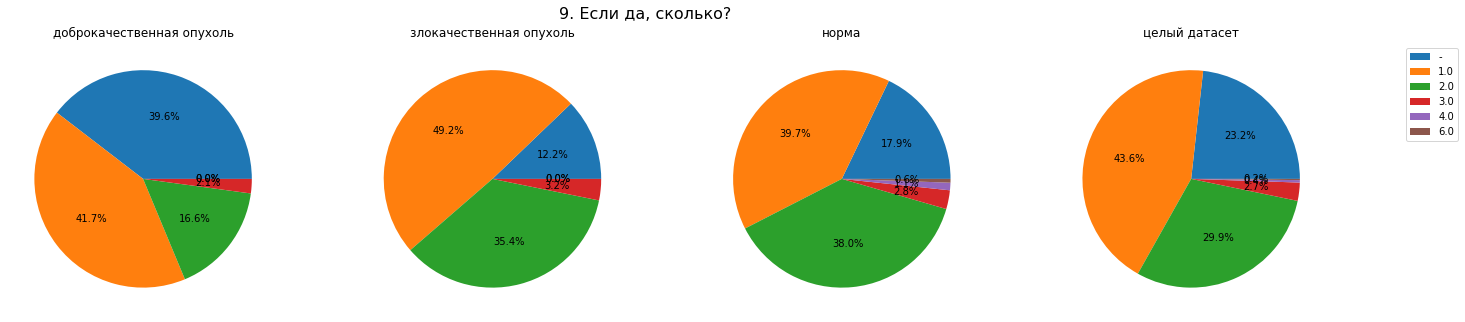

In [45]:
viz.plot_pies(df, defs.QUESTION_9, defs.LABEL)

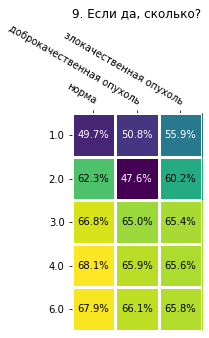

In [46]:
viz.plot_accuracy_matrix(df, defs.QUESTION_9)

### pre11. Есть ответ на вопрос 11?

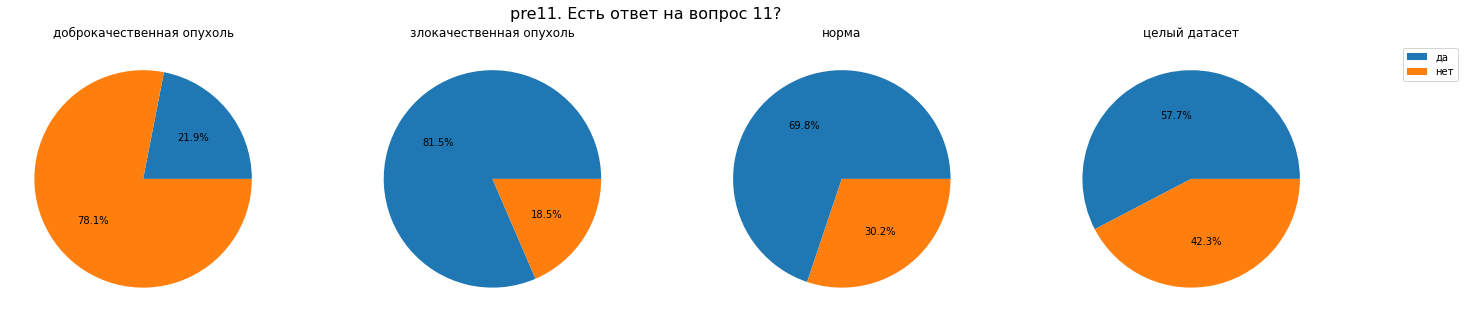

In [47]:
viz.plot_pies(df, 'pre11. Есть ответ на вопрос 11?', defs.LABEL)

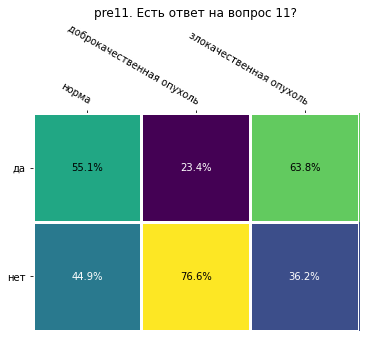

In [48]:
viz.plot_accuracy_matrix(df, 'pre11. Есть ответ на вопрос 11?')

### 11. Если да, как часто вы общаетесь? (с совершеннолетними детьми)

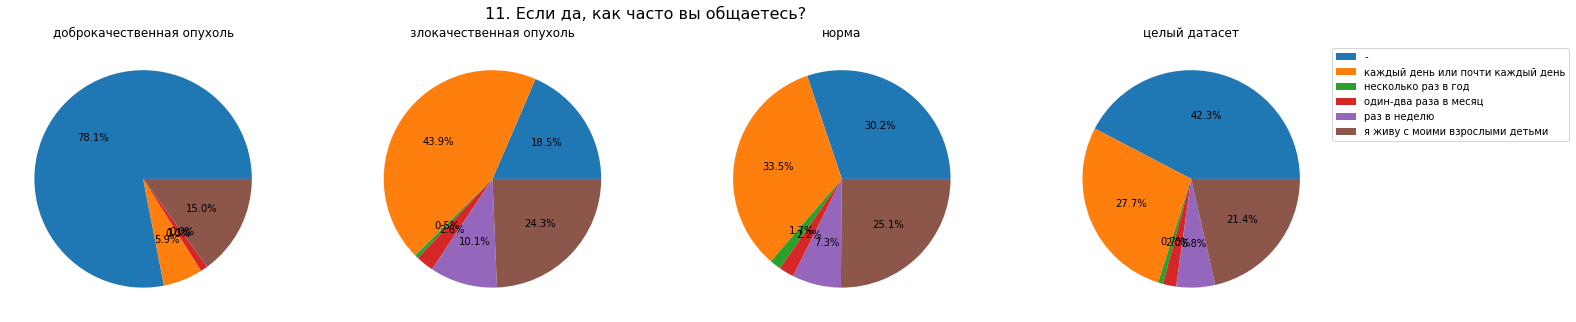

In [49]:
viz.plot_pies(df, defs.QUESTION_11, defs.LABEL)

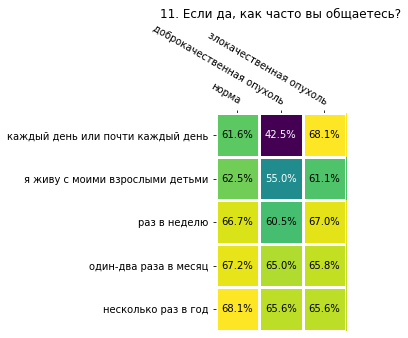

In [50]:
viz.plot_accuracy_matrix(df, defs.QUESTION_11)

### 12. Сколько человек живут вместе с Вами?

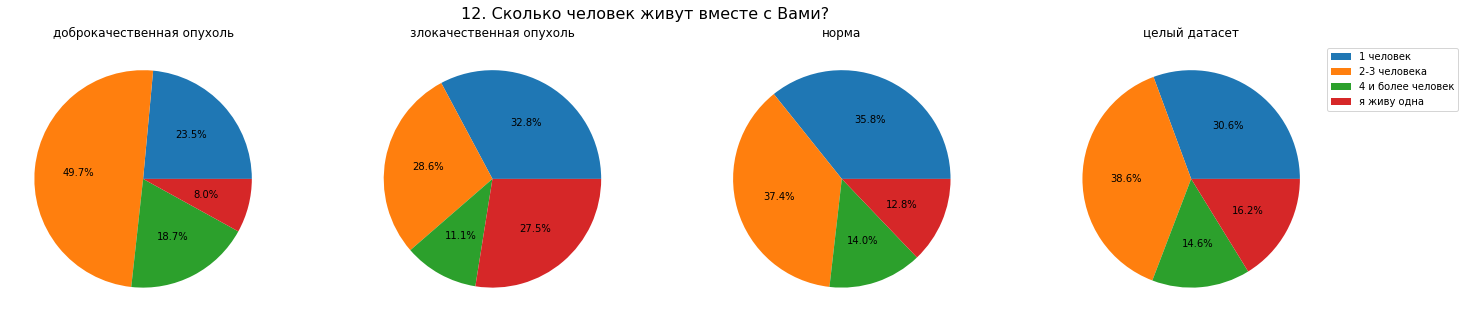

In [51]:
viz.plot_pies(df, defs.QUESTION_12, defs.LABEL)

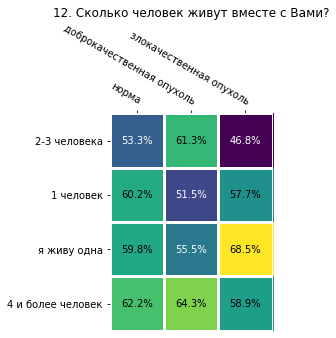

In [52]:
viz.plot_accuracy_matrix(df, defs.QUESTION_12)

### 13. Каковы Ваши взаимоотношения с соседями?

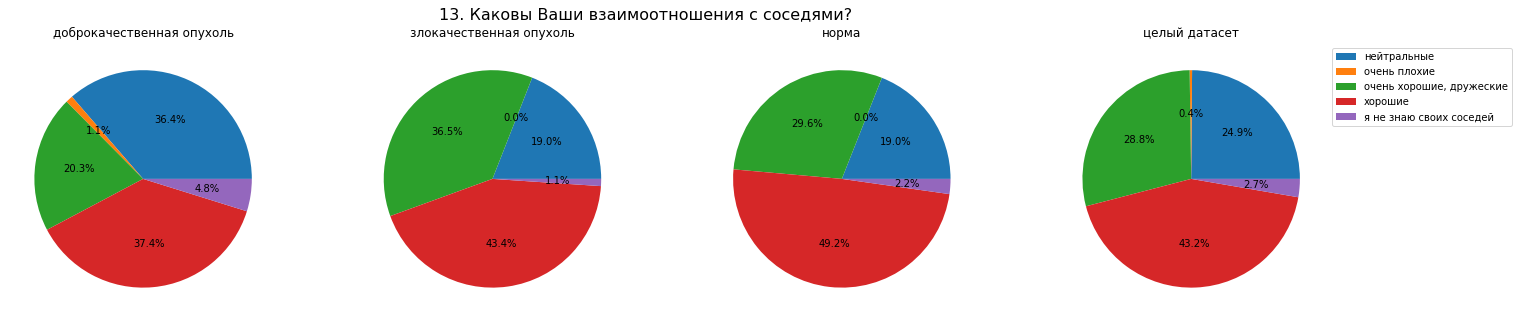

In [53]:
viz.plot_pies(df, defs.QUESTION_13, defs.LABEL)

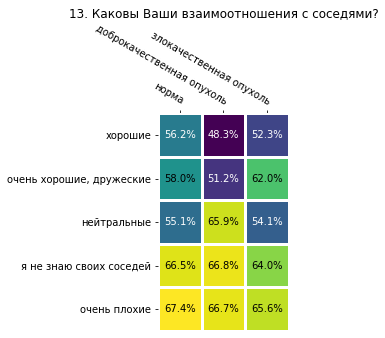

In [54]:
viz.plot_accuracy_matrix(df, defs.QUESTION_13)

### 14. Как часто Вы встречаетесь с друзьями?

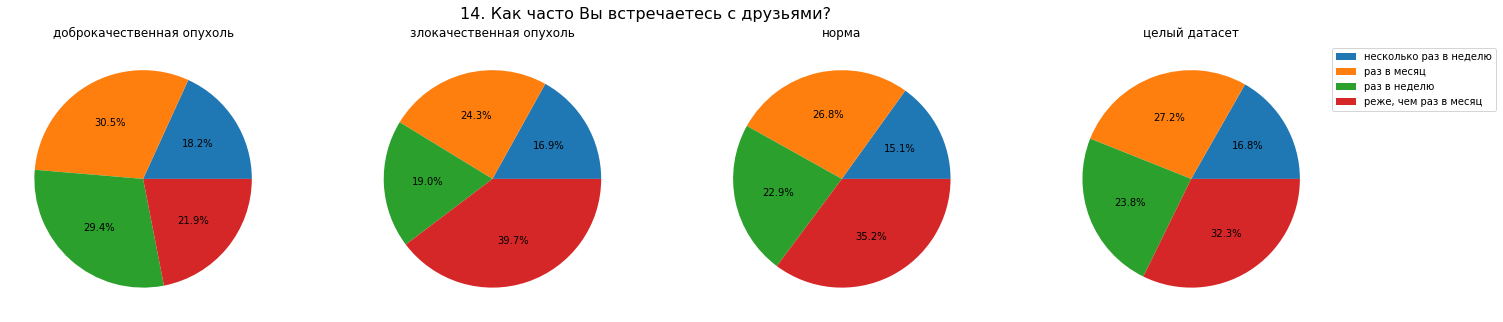

In [55]:
viz.plot_pies(df, defs.QUESTION_14, defs.LABEL)

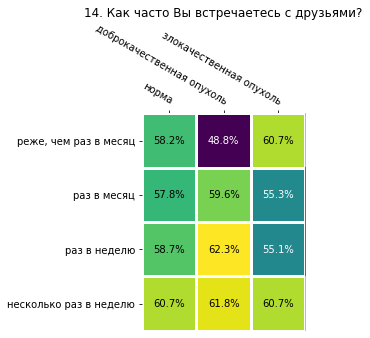

In [56]:
viz.plot_accuracy_matrix(df, defs.QUESTION_14)

### 15. Есть ли у Вас домашние питомцы? (да/нет)

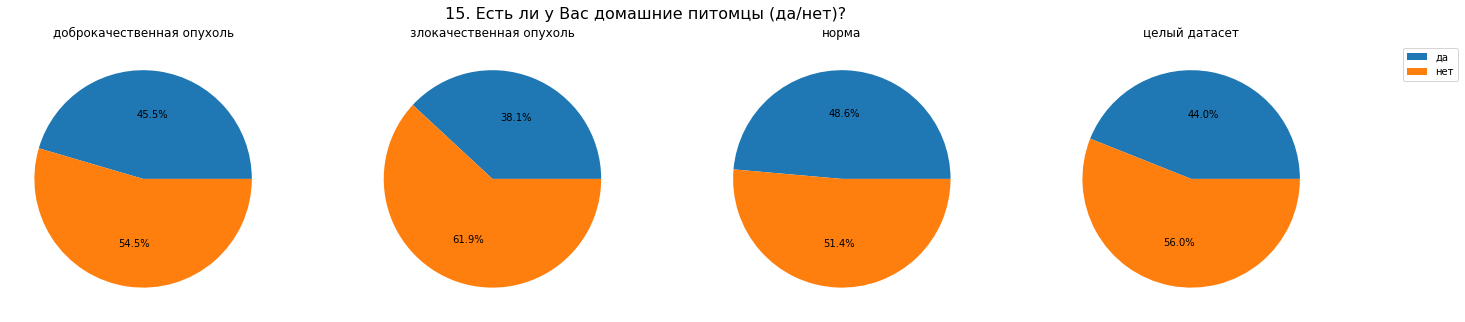

In [57]:
viz.plot_pies(df, defs.QUESTION_15, defs.LABEL)

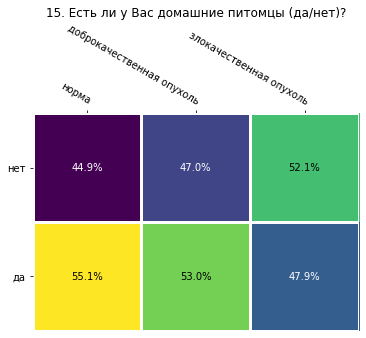

In [58]:
viz.plot_accuracy_matrix(df, defs.QUESTION_15)

### 16. В течение последних 7 дней, как часто Вы практиковали тяжелые физические нагрузки?

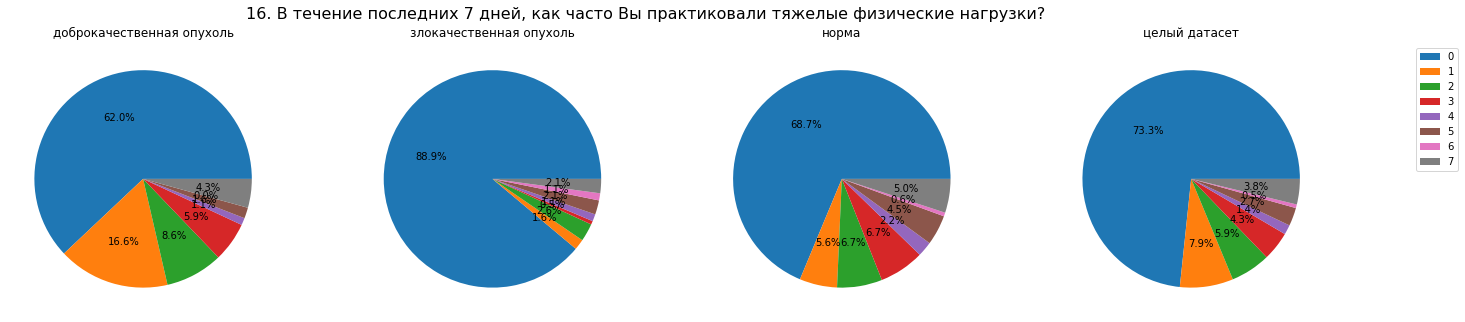

In [59]:
viz.plot_pies(df, defs.QUESTION_16, defs.LABEL)

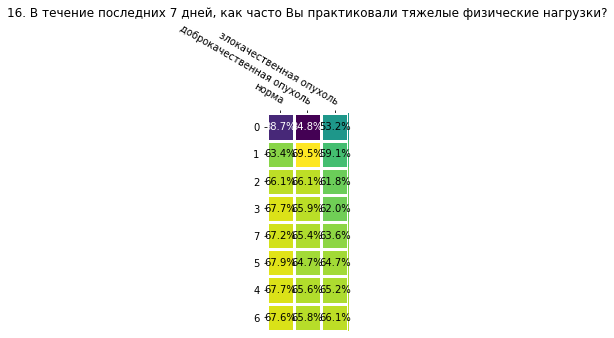

In [60]:
viz.plot_accuracy_matrix(df, defs.QUESTION_16)

### 17. В течение последних 7 дней, как часто Вы практиковали умеренные физические нагрузки?

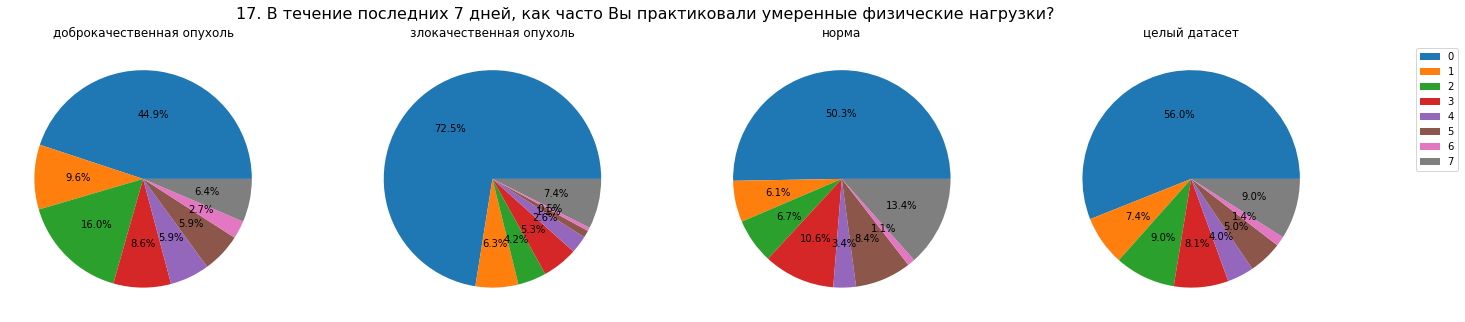

In [61]:
viz.plot_pies(df, defs.QUESTION_17, defs.LABEL)

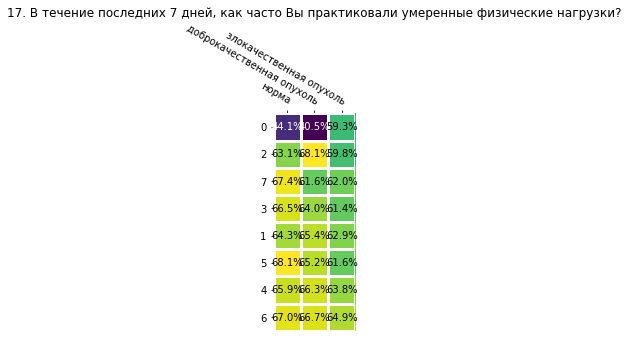

In [62]:
viz.plot_accuracy_matrix(df, defs.QUESTION_17)

### 18. В течение последних 7 дней, как часто Вы ходили пешком минимум 10 минут без перерыва?

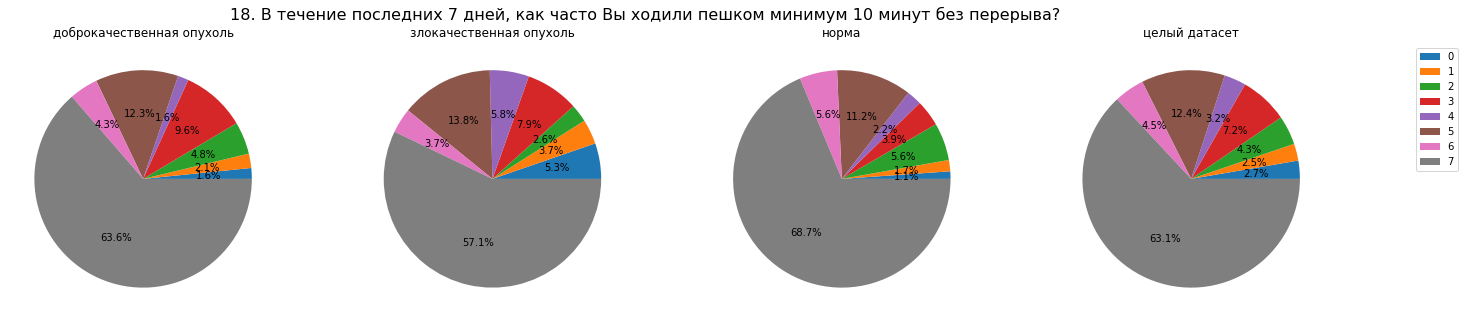

In [63]:
viz.plot_pies(df, defs.QUESTION_18, defs.LABEL)

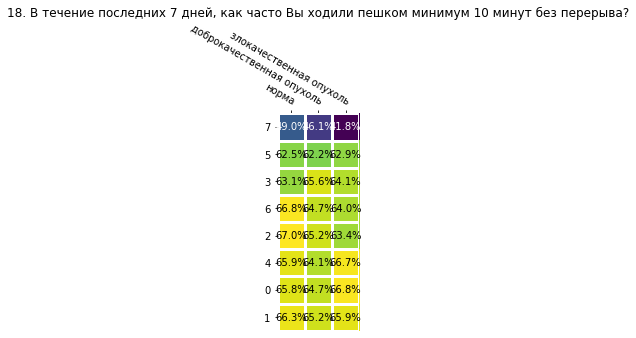

In [64]:
viz.plot_accuracy_matrix(df, defs.QUESTION_18)

### 19. Уровень Вашего образования?

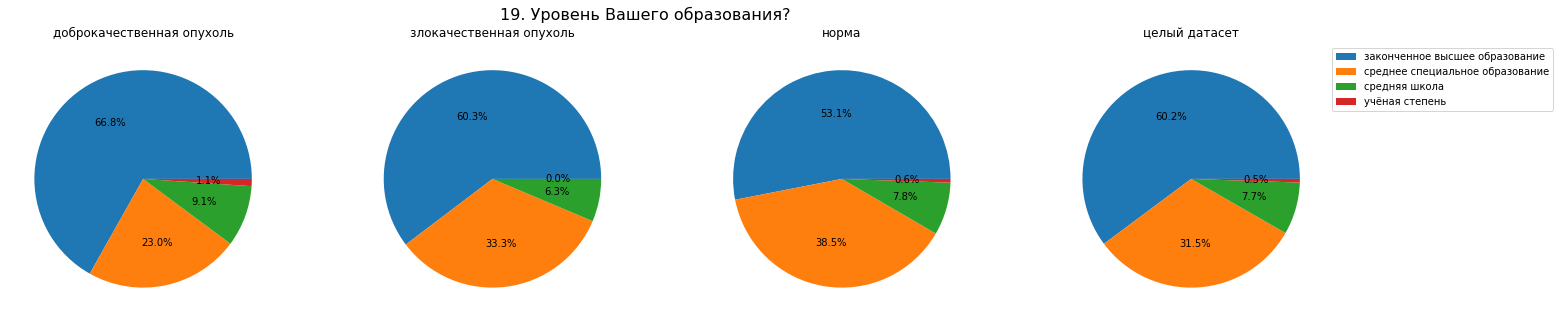

In [65]:
viz.plot_pies(df, defs.QUESTION_19, defs.LABEL)

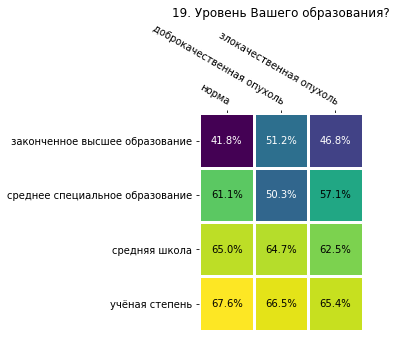

In [66]:
viz.plot_accuracy_matrix(df, defs.QUESTION_19)

### pre20. Есть ответ на вопрос 20?

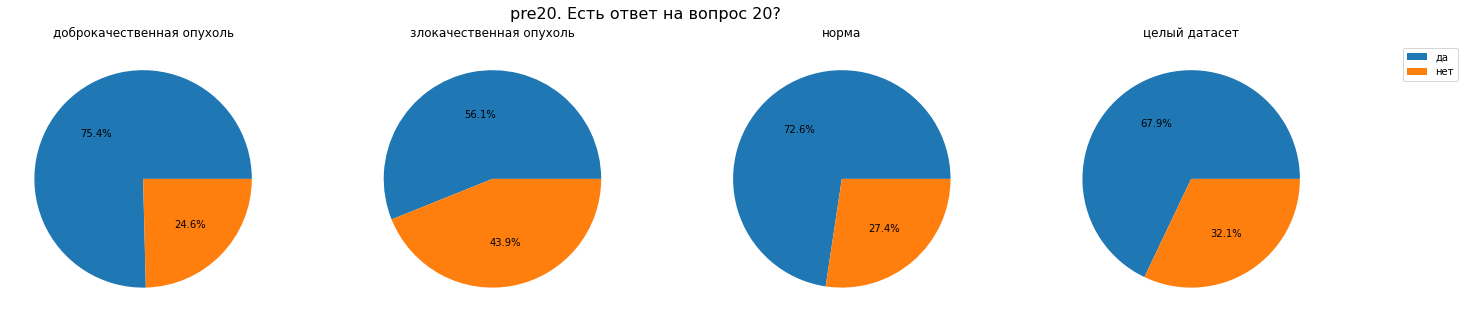

In [67]:
viz.plot_pies(df, 'pre20. Есть ответ на вопрос 20?', defs.LABEL)

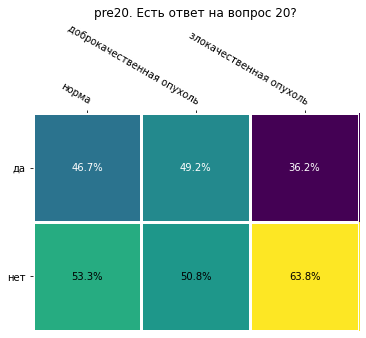

In [68]:
viz.plot_accuracy_matrix(df, 'pre20. Есть ответ на вопрос 20?')

### 20. Каков уровень образования Вашего партнёра? (если применимо)

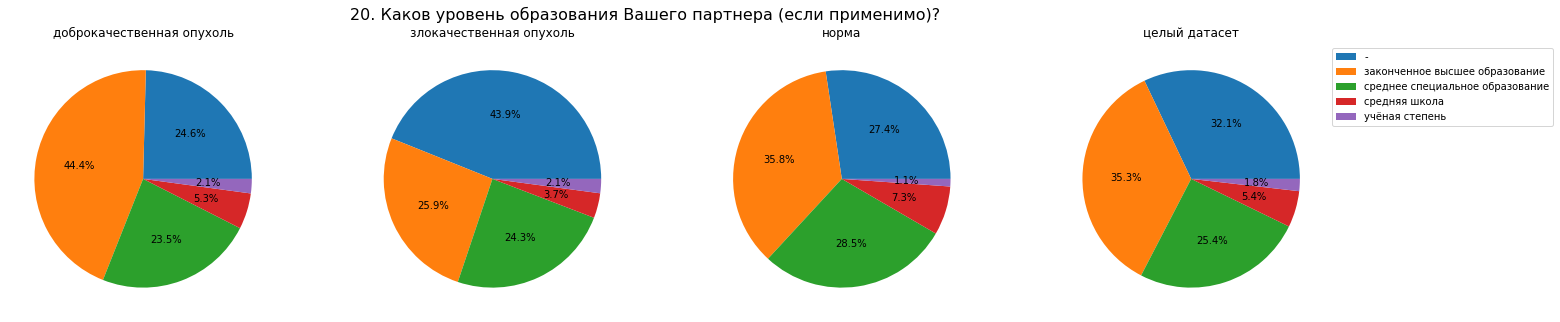

In [69]:
viz.plot_pies(df, defs.QUESTION_20, defs.LABEL)

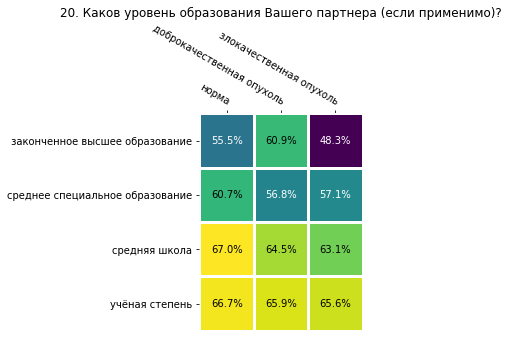

In [70]:
viz.plot_accuracy_matrix(df, defs.QUESTION_20)

### 22. Как долго Вы проживаете в этом месте? (в годах)

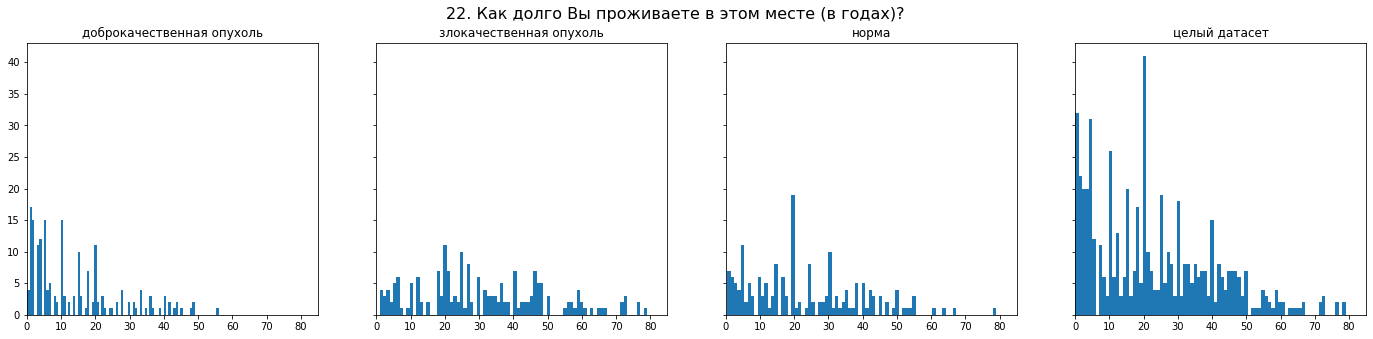

In [71]:
viz.plot_hists(df, defs.QUESTION_22, defs.LABEL, bins=80, xlim=(0, 85))

### 23. Каков тип Вашего дома?

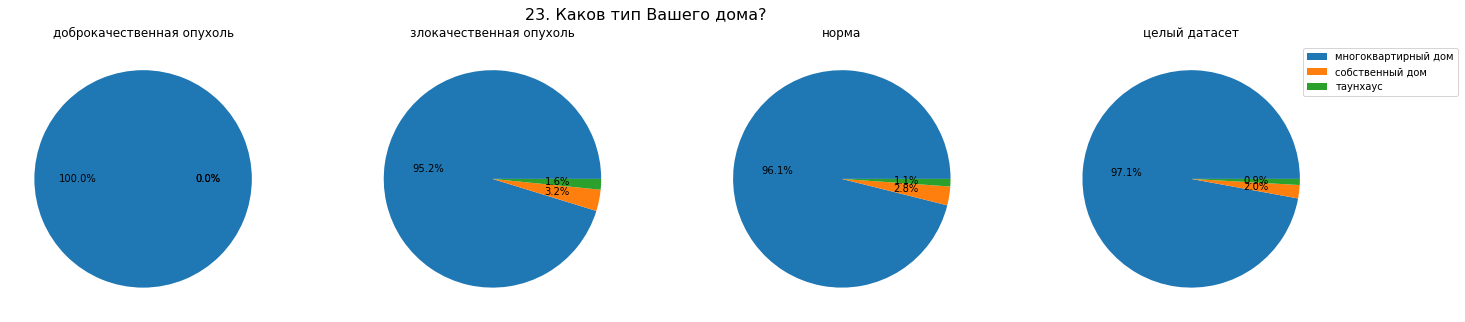

In [72]:
viz.plot_pies(df, defs.QUESTION_23, defs.LABEL)

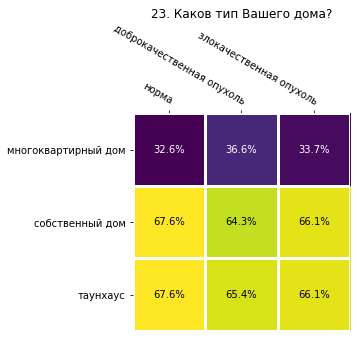

In [73]:
viz.plot_accuracy_matrix(df, defs.QUESTION_23)

### 24. Если Вы живёте в многоквартирном доме, то на каком этаже?

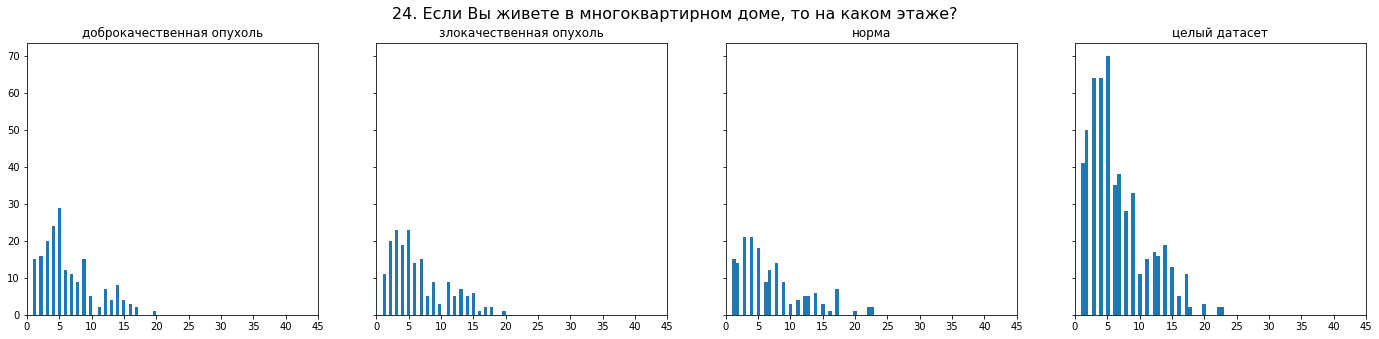

In [74]:
viz.plot_hists(df, defs.QUESTION_24, defs.LABEL, bins=40, xlim=(0, 45))

### 25. Каким транспортом Вы обычно пользуетесь?

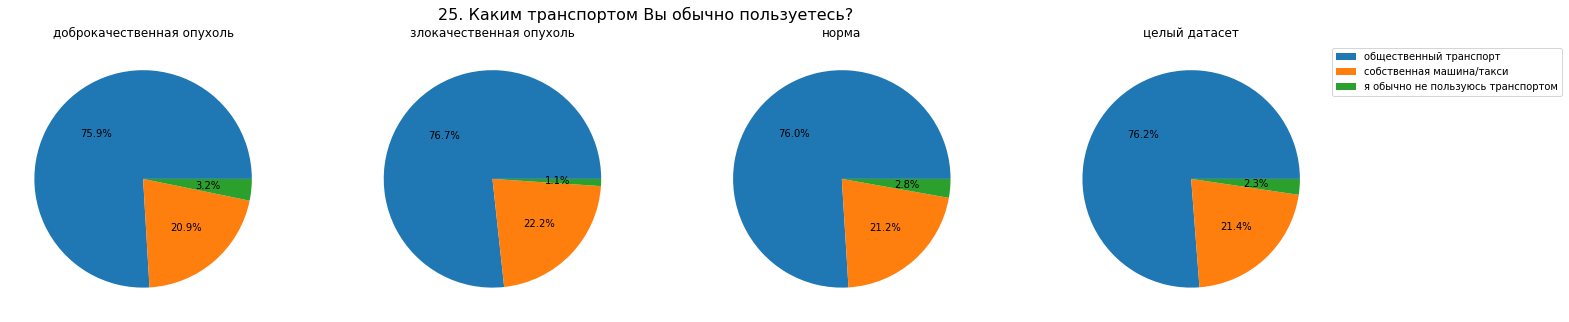

In [75]:
viz.plot_pies(df, defs.QUESTION_25, defs.LABEL)

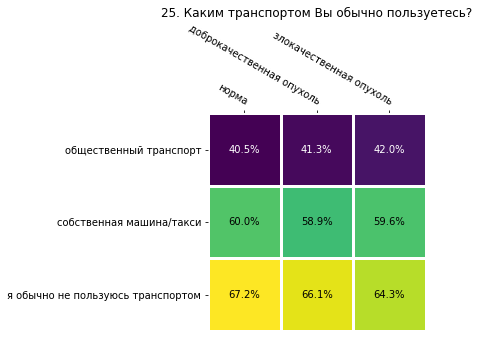

In [76]:
viz.plot_accuracy_matrix(df, defs.QUESTION_25)

### 26. Сколько времени занимает Ваш путь до работы в одну сторону?

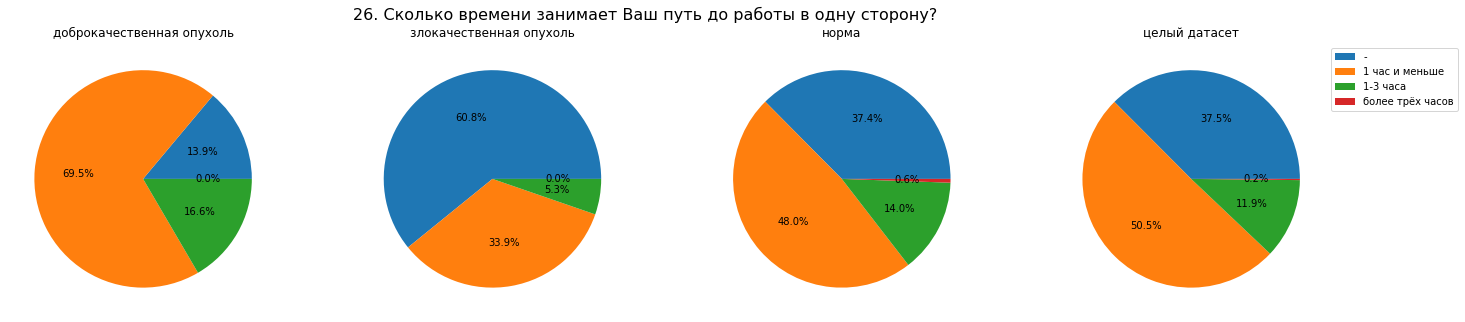

In [77]:
viz.plot_pies(df, defs.QUESTION_26, defs.LABEL)

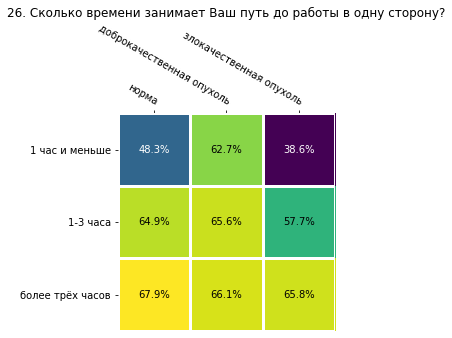

In [78]:
viz.plot_accuracy_matrix(df, defs.QUESTION_26)

### 27. Каков тип Вашей занятости?

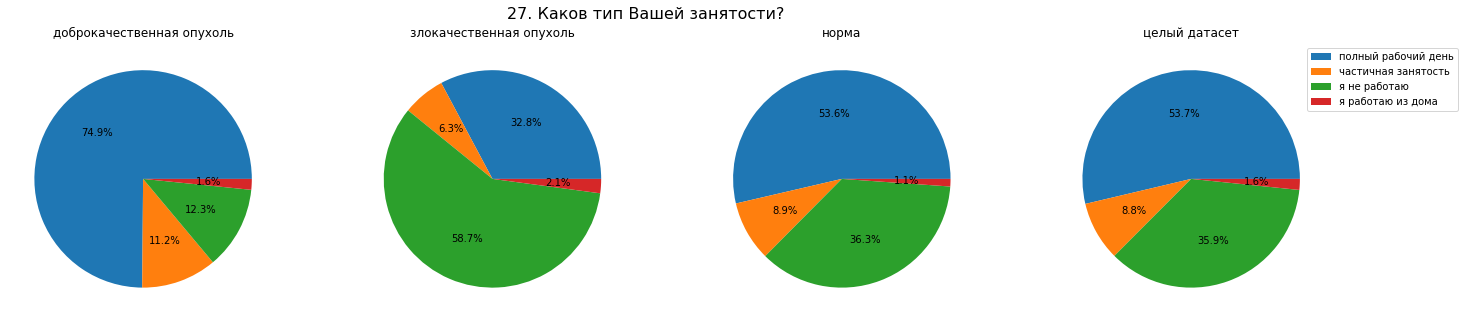

In [79]:
viz.plot_pies(df, defs.QUESTION_27, defs.LABEL)

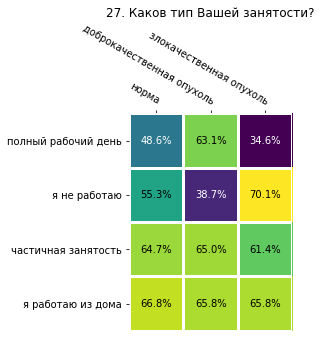

In [80]:
viz.plot_accuracy_matrix(df, defs.QUESTION_27)

### 28. Каковы Ваши предпочтения в пище?

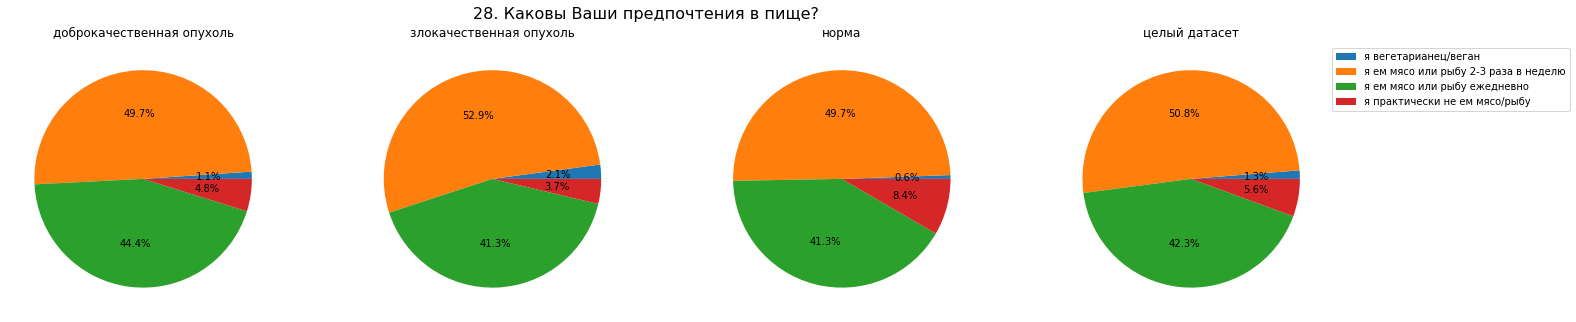

In [81]:
viz.plot_pies(df, defs.QUESTION_28, defs.LABEL)

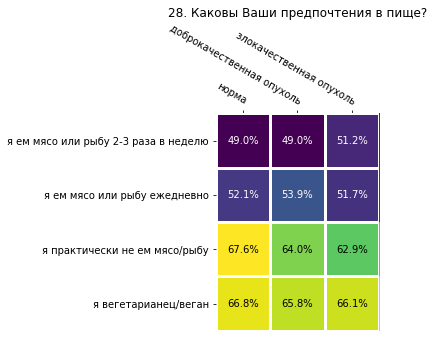

In [82]:
viz.plot_accuracy_matrix(df, defs.QUESTION_28)

### 29. Каков тип Вашего питания?

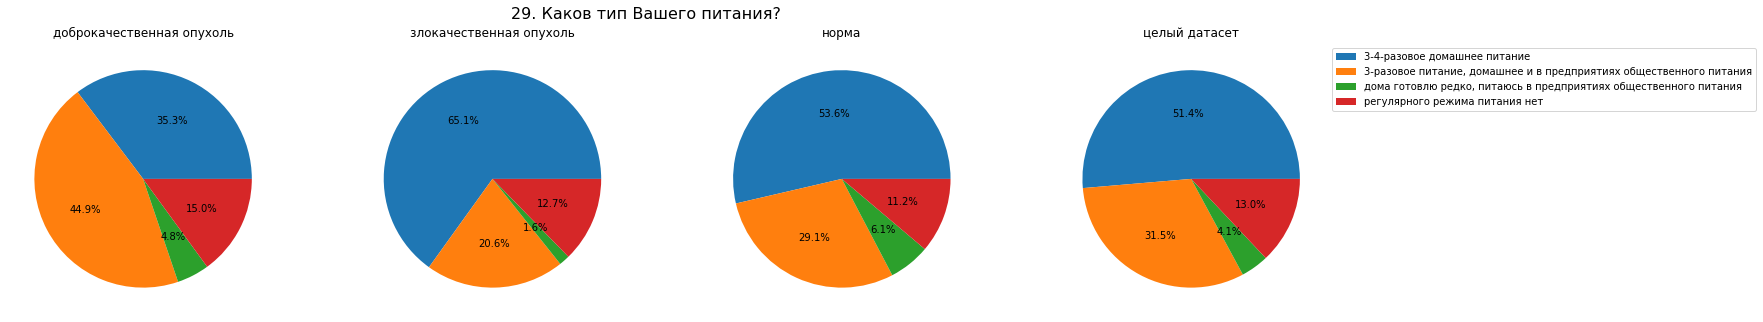

In [83]:
viz.plot_pies(df, defs.QUESTION_29, defs.LABEL)

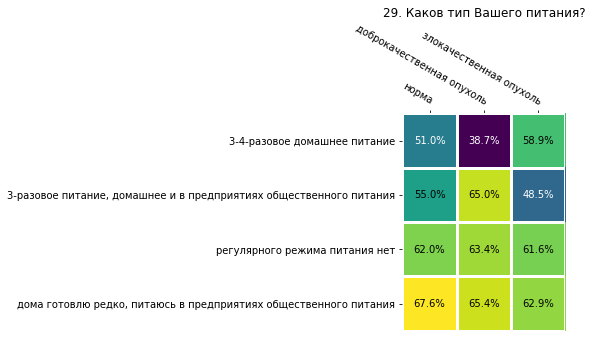

In [84]:
viz.plot_accuracy_matrix(df, defs.QUESTION_29)

### 30. Вы курите? (да/нет)

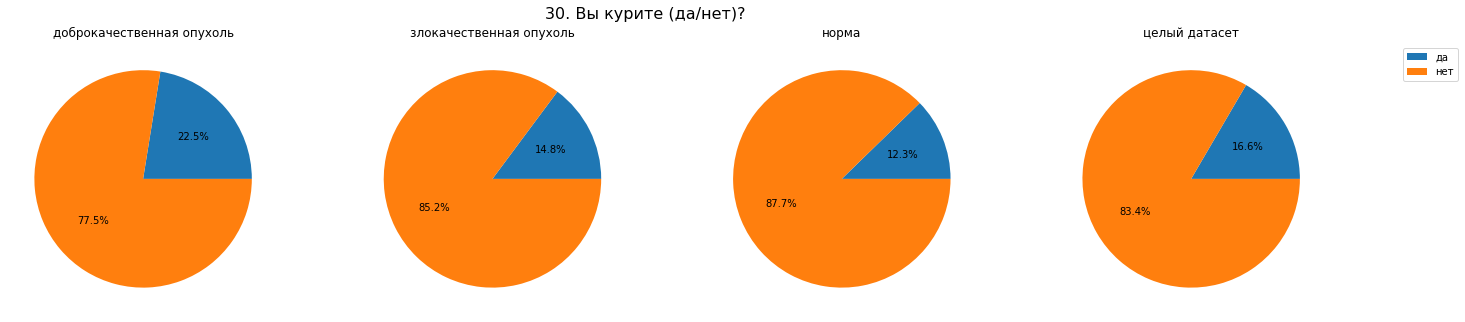

In [85]:
viz.plot_pies(df, defs.QUESTION_30, defs.LABEL)

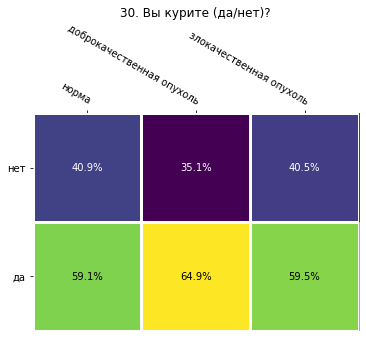

In [86]:
viz.plot_accuracy_matrix(df, defs.QUESTION_30)

### 31. Количество родов

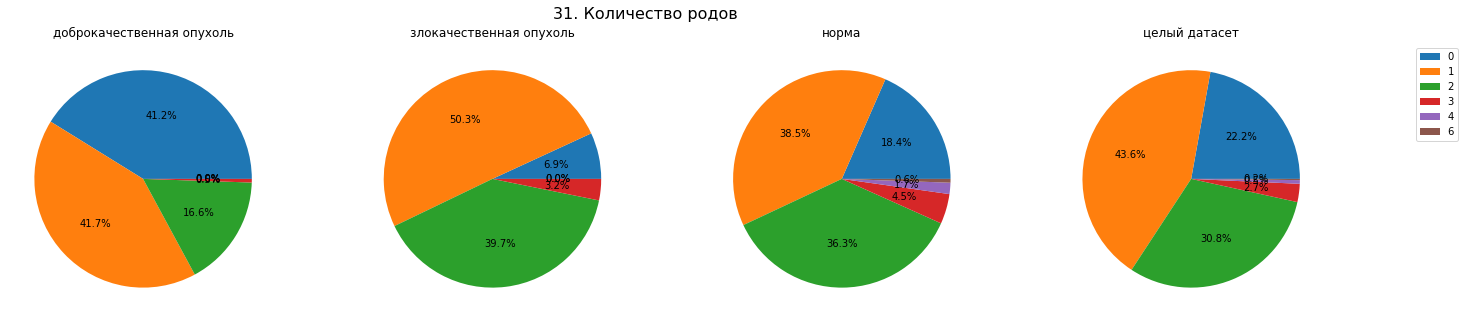

In [87]:
viz.plot_pies(df, defs.QUESTION_31, defs.LABEL)

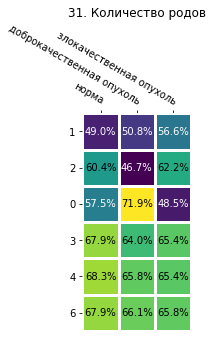

In [88]:
viz.plot_accuracy_matrix(df, defs.QUESTION_31)

### 32. Количество прерванных беременностей

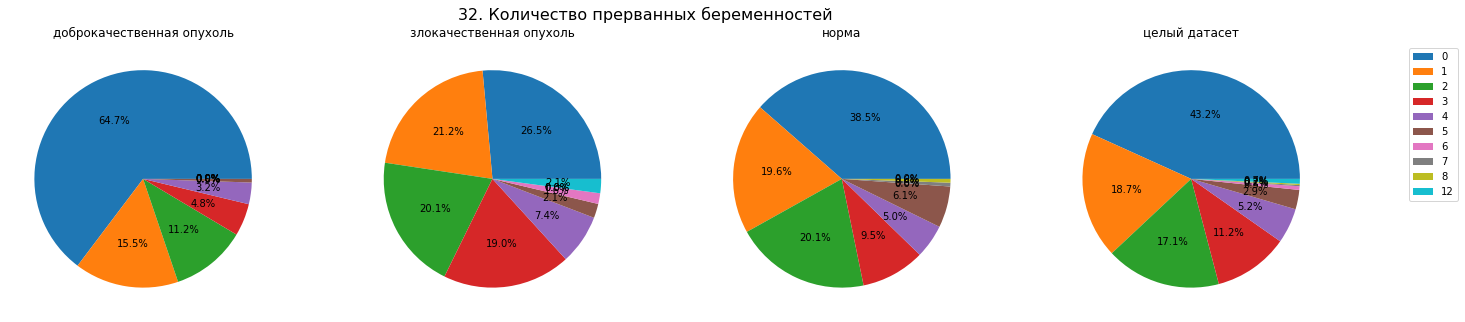

In [89]:
viz.plot_pies(df, defs.QUESTION_32, defs.LABEL)

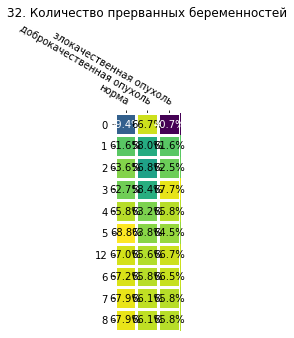

In [90]:
viz.plot_accuracy_matrix(df, defs.QUESTION_32)

### 33. Гинекологические заболевания (да/нет)

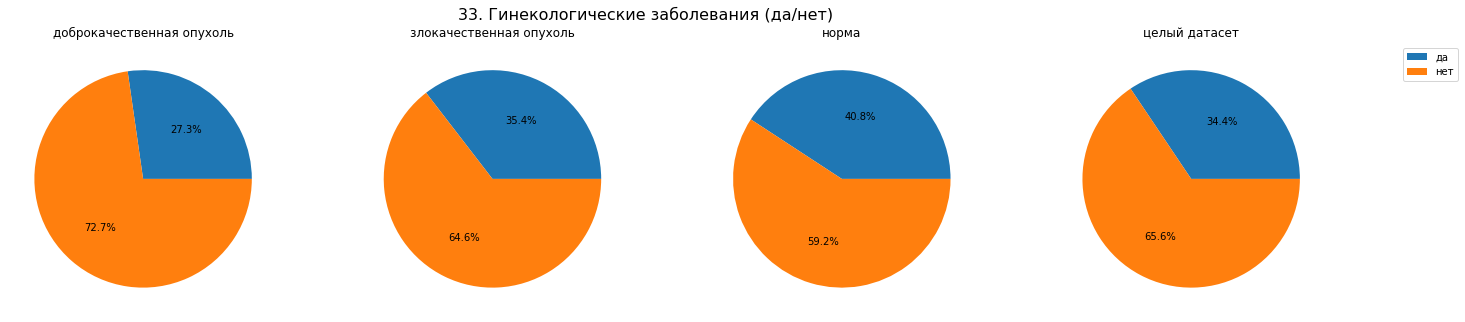

In [91]:
viz.plot_pies(df, defs.QUESTION_33, defs.LABEL)

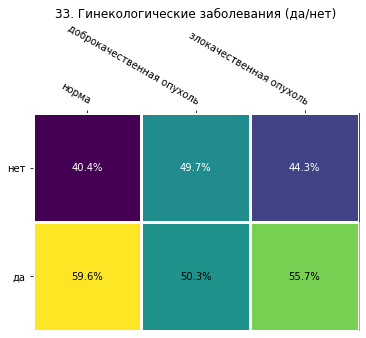

In [92]:
viz.plot_accuracy_matrix(df, defs.QUESTION_33)

### 34. Заболевания щитовидной железы (да/нет)

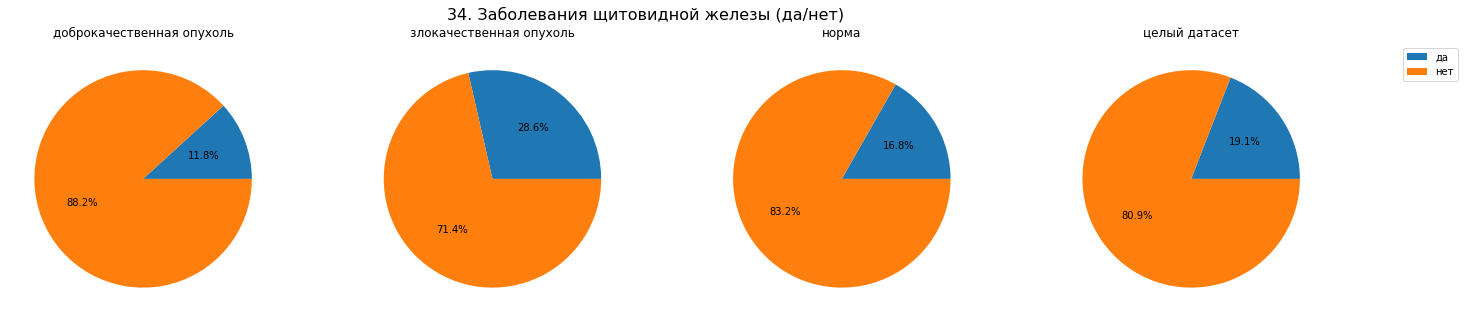

In [93]:
viz.plot_pies(df, defs.QUESTION_34, defs.LABEL)

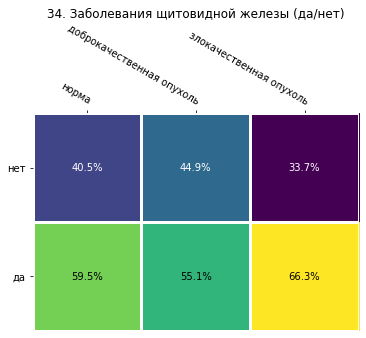

In [94]:
viz.plot_accuracy_matrix(df, defs.QUESTION_34)

### 35. Наследственность (да/нет)

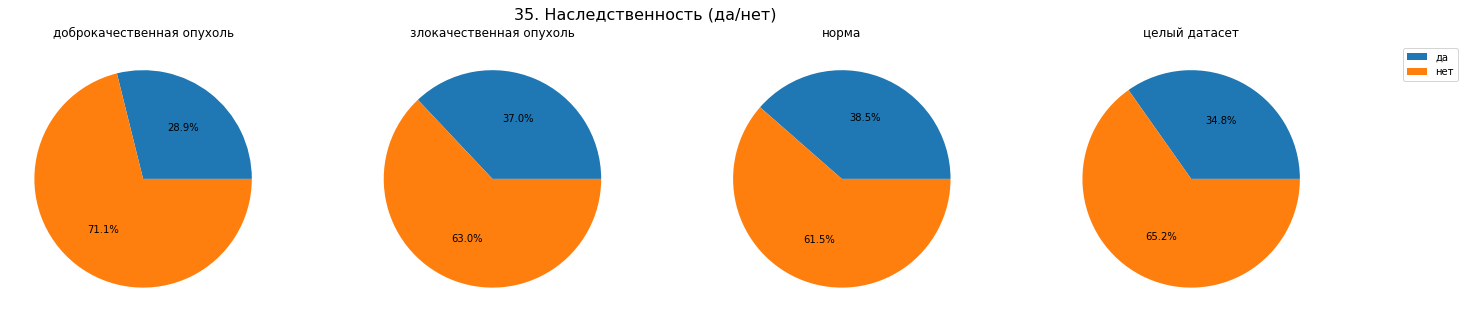

In [95]:
viz.plot_pies(df, defs.QUESTION_35, defs.LABEL)

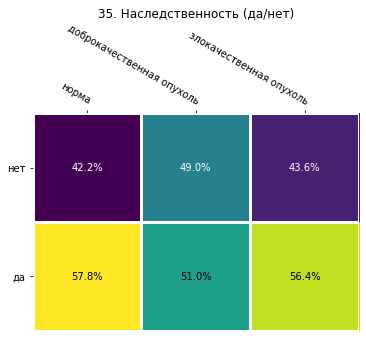

In [96]:
viz.plot_accuracy_matrix(df, defs.QUESTION_35)